In [1]:
import keras
from keras import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
from PIL import Image
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

np.random.seed(42)

In [2]:
def get_path(directory, data):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            get_path(folder_path, data)
        else:
            fruit_parts = directory.split("\\")
            fruit_name = fruit_parts[-2] if len(fruit_parts[-1].split()) > 1 else fruit_parts[-1]
            data.append((folder_path, fruit_name))

In [3]:
directory = r".\data\archive"
data = []

get_path(directory, data)
df = pd.DataFrame(data, columns=['path', 'fruit'])

# Modelo 1

El primer modelo que probamos es con la misma cantidad de imagenes por fruta.  
La resolucion de las imagenes es de 100x100.

In [4]:
# sacamos 1/5 de df, en machine learning compobamos que es una cantidad de datos aceptable
# los modelos no suelen tardar demasiado (mas de 2h) y siempre se puede ajustar
samples = round(df.shape[0]/5)

fruit_weights = 1 / df['fruit'].value_counts(normalize=True)
df_s = df.sample(samples, weights=df['fruit'].map(fruit_weights), random_state=42)

In [5]:
# usamos LabelEncoder y lo anadimos a df para plotear imagenes mas adelante
le = LabelEncoder()
df_s["label"] = le.fit_transform(df_s["fruit"])

In [6]:
# creamos X e y, cargamos las imagenes
img_paths = df_s['path'].values
img_labels = df_s['label'].values
X = []
y = []
    
for i, path in enumerate(img_paths):
    img =  plt.imread(path)
    img = cv2.resize(img, (100,100))
    label = img_labels[i]
    X.append(img)
    y.append(label)

In [7]:
X = np.array(X)
y = np.array(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape

(11288, 100, 100, 3)

In [9]:
y_train = to_categorical(y_train)

# Modelo 0.1

Descartado. 

In [12]:
model_01 = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=6, input_shape=(100,100,3), 
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=64, kernel_size=3,
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=128, kernel_size=3,
                     activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(15, activation='softmax')
])

model_01.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
model_01.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      3488      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 12, 12, 128)      

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model_01.fit(X_train, y_train, epochs=100, validation_split = 0.1, 
                    callbacks = early_stopping, verbose = 1)

Epoch 1/100


318/318 [==============================] - 73s 223ms/step - loss: 2.7170 - accuracy: 0.0751 - val_loss: 2.6824 - val_accuracy: 0.0841
Epoch 2/100
318/318 [==============================] - 71s 223ms/step - loss: 2.6881 - accuracy: 0.0780 - val_loss: 2.6825 - val_accuracy: 0.0841
Epoch 3/100
318/318 [==============================] - 72s 227ms/step - loss: 2.6847 - accuracy: 0.0803 - val_loss: 2.6821 - val_accuracy: 0.0841
Epoch 4/100
318/318 [==============================] - 77s 242ms/step - loss: 2.6987 - accuracy: 0.0822 - val_loss: 2.6798 - val_accuracy: 0.1089
Epoch 5/100
318/318 [==============================] - 80s 252ms/step - loss: 2.4623 - accuracy: 0.2000 - val_loss: 1.8832 - val_accuracy: 0.4376
Epoch 6/100
318/318 [==============================] - 75s 236ms/step - loss: 1.9521 - accuracy: 0.3521 - val_loss: 1.3328 - val_accuracy: 0.6165
Epoch 7/100
318/318 [==============================] - 76s 238ms/step - loss: 1.6695 - accuracy: 0.4342 - val_loss: 0.9072

In [15]:
y_test = to_categorical(y_test)

test_loss, test_accuracy = model_01.evaluate(X_test, y_test)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

89/89 [==============================] - 6s 65ms/step - loss: 0.3271 - accuracy: 0.9185
Test loss:  0.3270778954029083
Test accuracy:  0.9184975028038025


# Modelo 1

In [10]:
model_1 = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(100,100,3), 
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=128, kernel_size=(3,3),
                     activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=256, kernel_size=(3,3),
                     activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(15, activation='softmax')
])

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 128)       0

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

In [13]:
history = model_1.fit(X_train, y_train, epochs=100, validation_split = 0.1, 
                    callbacks = early_stopping, verbose = 1)

Epoch 1/100


318/318 [==============================] - 96s 294ms/step - loss: 2.7787 - accuracy: 0.0780 - val_loss: 2.6885 - val_accuracy: 0.0841
Epoch 2/100
318/318 [==============================] - 94s 295ms/step - loss: 2.6202 - accuracy: 0.1179 - val_loss: 2.1317 - val_accuracy: 0.2746
Epoch 3/100
318/318 [==============================] - 97s 304ms/step - loss: 2.0531 - accuracy: 0.2907 - val_loss: 1.4187 - val_accuracy: 0.5651
Epoch 4/100
318/318 [==============================] - 98s 307ms/step - loss: 1.7092 - accuracy: 0.4338 - val_loss: 1.0530 - val_accuracy: 0.7059
Epoch 5/100
318/318 [==============================] - 96s 303ms/step - loss: 1.2542 - accuracy: 0.5754 - val_loss: 0.6890 - val_accuracy: 0.8158
Epoch 6/100
318/318 [==============================] - 98s 310ms/step - loss: 1.2132 - accuracy: 0.6269 - val_loss: 0.6636 - val_accuracy: 0.8016
Epoch 7/100
318/318 [==============================] - 96s 302ms/step - loss: 0.9510 - accuracy: 0.6988 - val_loss: 0.4982

In [14]:
# comparamos accuracy en train y validation
acc_evol = {'Train accuracy': history.history['accuracy'], 
            'Validation accuracy': history.history['val_accuracy'], 
            'Epoch': range(1, 38)}

acc_evol = pd.DataFrame(acc_evol)

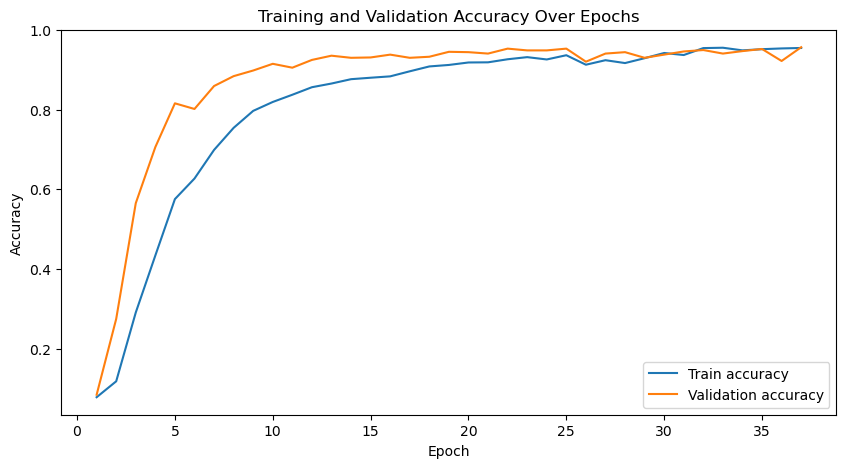

In [15]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=acc_evol, x='Epoch', y='Train accuracy', label='Train accuracy')
sns.lineplot(data=acc_evol, x='Epoch', y='Validation accuracy', label='Validation accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
y_test = to_categorical(y_test)

test_loss, test_accuracy = model_1.evaluate(X_test, y_test)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

89/89 [==============================] - 7s 78ms/step - loss: 0.1511 - accuracy: 0.9550
Test loss:  0.15109597146511078
Test accuracy:  0.9549964666366577


In [18]:
# pasamos el test sobre todos los valores que quedaron fuera de train/test
df_test = df[~df['path'].isin(df_s['path'])]
df_test["label"] = le.fit_transform(df_test["fruit"])
img_paths = df_test['path'].values
img_labels = df_test['label'].values
X = []
y = []
    
for i, path in enumerate(img_paths):
    img =  plt.imread(path)
    img = cv2.resize(img, (100,100))
    label = img_labels[i]
    X.append(img)
    y.append(label)
X = np.array(X)
y = np.array(y)
y = to_categorical(y)

C:\Users\ginge\AppData\Local\Temp\ipykernel_4456\593221743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["label"] = le.fit_transform(df_test["fruit"])


In [19]:
# diccionario para convertir labels 
fruit_names = dict(zip(le.transform(le.classes_), le.classes_))

In [20]:
test_loss, test_accuracy = model_1.evaluate(X, y)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

1764/1764 [==============================] - 160s 90ms/step - loss: 0.2231 - accuracy: 0.9445
Test loss:  0.2231365293264389
Test accuracy:  0.944471001625061


In [21]:
# escribiendo los labels predichos
pred = model_1.predict(X)
pred = pred.argmax(axis=1)
df_test['predicted_label'] = pred

1764/1764 [==============================] - 167s 94ms/step


C:\Users\ginge\AppData\Local\Temp\ipykernel_4456\3372751781.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_label'] = pred


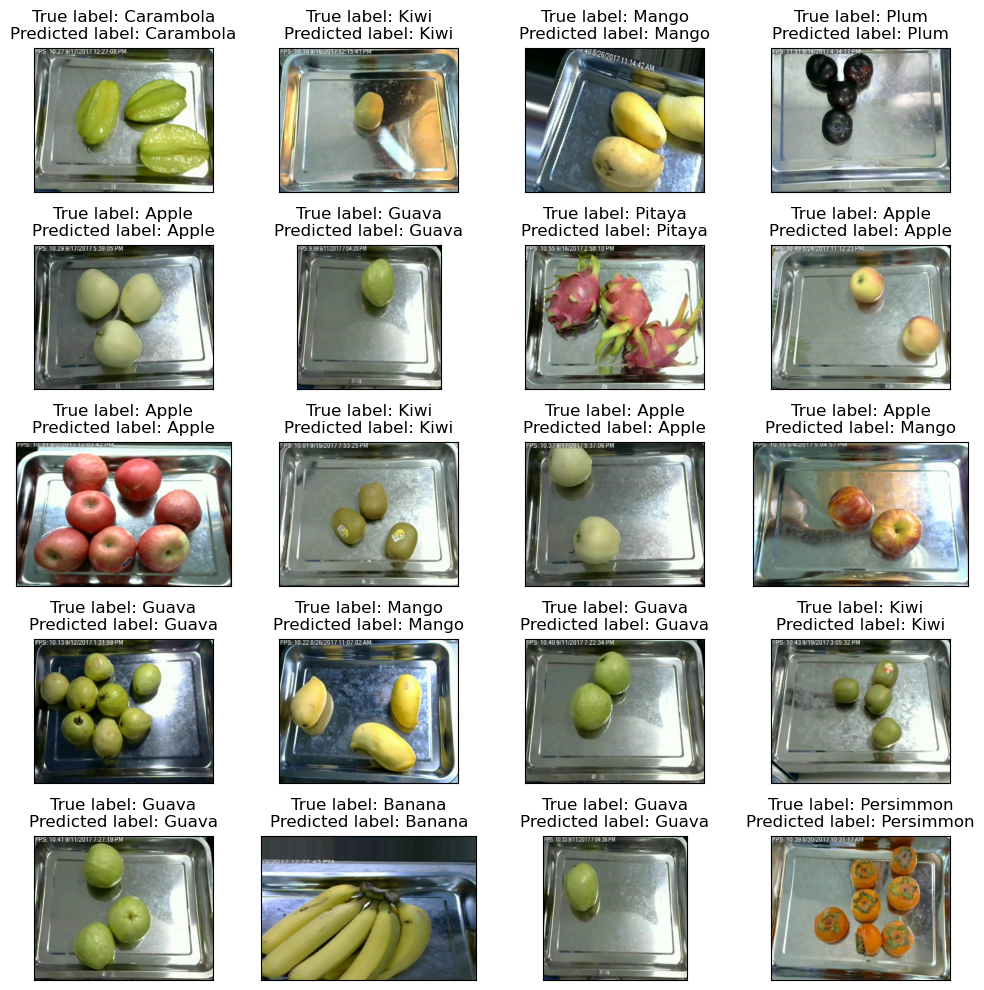

In [22]:
random = df_test.sample(20, random_state=42)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = random["path"].iloc[i]
    img = Image.open(img_path)
    ax.imshow(img)
    
    true_label_le = random['label'].iloc[i]
    predicted_label_le = random['predicted_label'].iloc[i]
    true_label = fruit_names.get(true_label_le)
    predicted_label = fruit_names.get(predicted_label_le)

    ax.set_title(f"True label: {true_label}\nPredicted label: {predicted_label}")
    
plt.tight_layout()
plt.show()

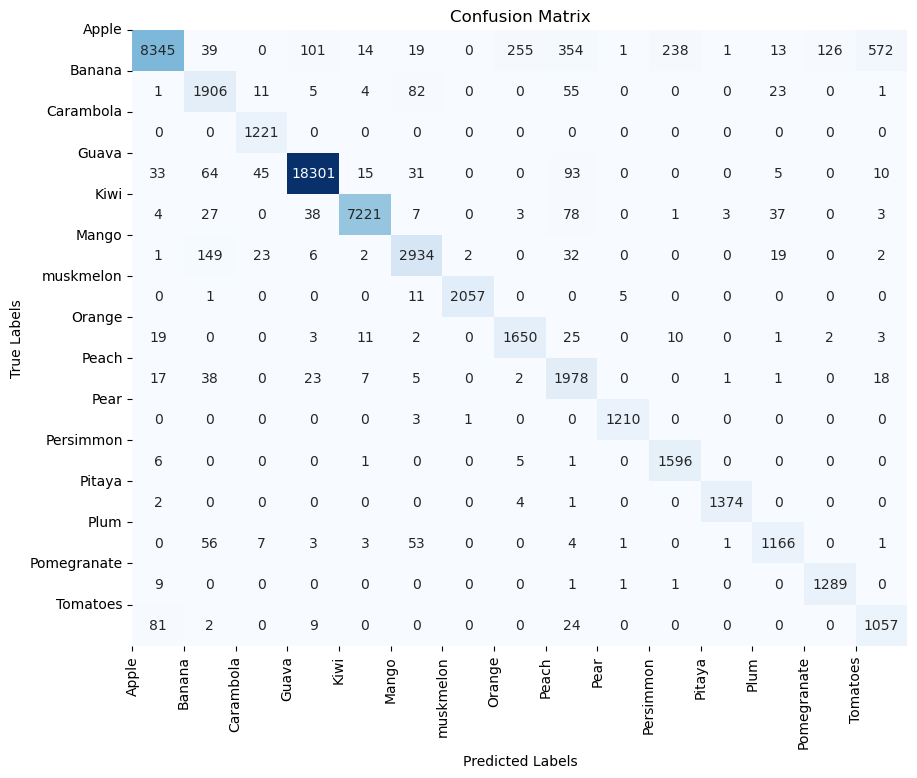

In [23]:
cm = confusion_matrix(np.array(df_test["label"]), np.array(df_test["predicted_label"]))
original_labels = df['fruit'].unique()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(fruit_names)), labels=original_labels, rotation=90)
plt.yticks(ticks=np.arange(len(fruit_names)), labels=original_labels, rotation=0)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

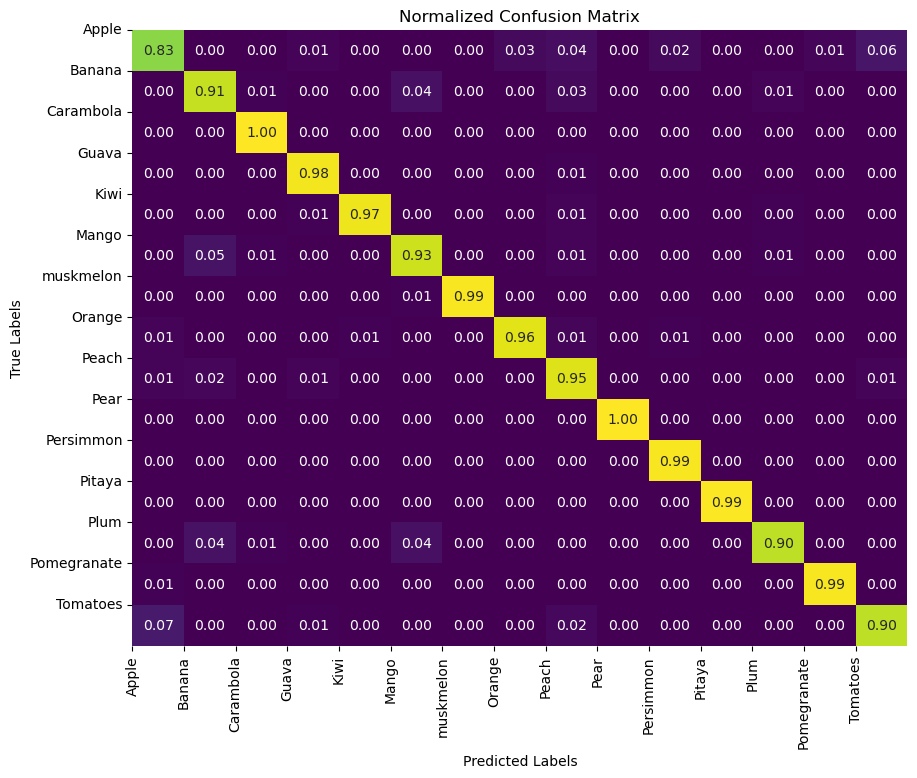

In [24]:
cm = confusion_matrix(np.array(df_test["label"]), np.array(df_test["predicted_label"]))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
original_labels = df['fruit'].unique()

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='viridis', cbar=False)
plt.xticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=90)
plt.yticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=0)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Al combropar accuracy sobre las imagenes que nos quedaron de todas que tenemos, observamos accuracy de 93%. Al mirar la matriz de confusión vemos que, por ejemplo, manzana se suele confundir más que otros tipos de fruta. Pobablemente sea porque la manzana tiene en total 5 subtipos que son diferentes. La solución podría ser incluir en el modelo también los subtipos. Así también podríamos conseguir cierto equilibrio en la cantidad de la fruta, ya que hay muchos datos de guayaba, manzana y kiwi (los tres que tienen subtipos) y menos de todos los demás.

# Modelo 2

El segundo modelo es de la resolucion 150x150.   
(Va muy lento y no mejora accuracy, así que quedamos con 100x100).   
Descartado.

In [137]:
img_paths = df_s['path'].values
img_labels = df_s['label'].values
X_150 = []
y_150 = []
    
for i, path in enumerate(img_paths):
    img =  plt.imread(path)
    img = cv2.resize(img, (150,150))
    label = img_labels[i]
    X_150.append(img)
    y_150.append(label)
    
X_150 = np.array(X)
y_150 = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_150, y_150, test_size=0.2)

y_train = to_categorical(y_train)

In [142]:
model_2 = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(150,150,3), 
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(filters=128, kernel_size=(3,3),
                     activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(filters=256, kernel_size=(3,3),
                     activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(15, activation='softmax')
])

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [143]:
model_2.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_99 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_99 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_100 (Conv2D)         (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_100 (MaxPool  (None, 37, 37, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_101 (Conv2D)         (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_101 (MaxPool  (None, 18, 18, 128)     

In [144]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

In [145]:
history = model_2.fit(X_train, y_train, epochs=100, validation_split = 0.1, 
                    callbacks = early_stopping, verbose = 1)

Epoch 1/100
318/318 [==============================] - 240s 745ms/step - loss: 2.7756 - accuracy: 0.0851 - val_loss: 2.6558 - val_accuracy: 0.1479
Epoch 2/100
318/318 [==============================] - 234s 736ms/step - loss: 2.6093 - accuracy: 0.1434 - val_loss: 2.1949 - val_accuracy: 0.2994
Epoch 3/100
318/318 [==============================] - 234s 736ms/step - loss: 2.1348 - accuracy: 0.2977 - val_loss: 1.5102 - val_accuracy: 0.5492
Epoch 4/100
318/318 [==============================] - 236s 742ms/step - loss: 1.4955 - accuracy: 0.5033 - val_loss: 0.8728 - val_accuracy: 0.7467
Epoch 5/100
318/318 [==============================] - 232s 730ms/step - loss: 1.0805 - accuracy: 0.6502 - val_loss: 0.7361 - val_accuracy: 0.8069
Epoch 6/100
318/318 [==============================] - 241s 759ms/step - loss: 0.8480 - accuracy: 0.7174 - val_loss: 0.5255 - val_accuracy: 0.8450
Epoch 7/100
318/318 [==============================] - 235s 740ms/step - loss: 0.6940 - accuracy: 0.7656 - val_loss: 0

# Modelo 3

Vamos a probar uno sin controlar directamente la cantidad de imagenes de cada fruta.  

In [10]:
samples = round(df.shape[0]/5)
df_s = df.sample(samples, random_state=42)

le = LabelEncoder()
df_s["label"] = le.fit_transform(df_s["fruit"])

img_paths = df_s['path'].values
img_labels = df_s['label'].values
X = []
y = []
    
for i, path in enumerate(img_paths):
    img =  plt.imread(path)
    img = cv2.resize(img, (100,100))
    label = img_labels[i]
    X.append(img)
    y.append(label)
    
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = to_categorical(y_train)

In [11]:
model_3 = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(100,100,3), 
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(filters=128, kernel_size=(3,3),
                     activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(filters=256, kernel_size=(3,3),
                     activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(15, activation='softmax')
])

model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 128)       0

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
history = model_3.fit(X_train, y_train, epochs=100, validation_split = 0.1, 
                    callbacks = early_stopping, verbose = 1)

Epoch 1/100


318/318 [==============================] - 91s 277ms/step - loss: 2.4218 - accuracy: 0.2883 - val_loss: 2.1978 - val_accuracy: 0.3446
Epoch 2/100
318/318 [==============================] - 88s 276ms/step - loss: 2.3817 - accuracy: 0.3503 - val_loss: 1.7914 - val_accuracy: 0.3942
Epoch 3/100
318/318 [==============================] - 90s 282ms/step - loss: 1.7527 - accuracy: 0.4160 - val_loss: 1.3174 - val_accuracy: 0.5810
Epoch 4/100
318/318 [==============================] - 94s 297ms/step - loss: 1.4088 - accuracy: 0.5477 - val_loss: 0.8368 - val_accuracy: 0.7307
Epoch 5/100
318/318 [==============================] - 93s 293ms/step - loss: 1.0660 - accuracy: 0.6286 - val_loss: 0.6910 - val_accuracy: 0.7777
Epoch 6/100
318/318 [==============================] - 96s 301ms/step - loss: 0.8466 - accuracy: 0.6908 - val_loss: 0.4837 - val_accuracy: 0.8556
Epoch 7/100
318/318 [==============================] - 99s 312ms/step - loss: 0.9610 - accuracy: 0.7044 - val_loss: 1.2131

In [14]:
acc_evol = {'Train accuracy': history.history['accuracy'], 
            'Validation accuracy': history.history['val_accuracy'], 
            'Epoch': range(1, 63)}

acc_evol = pd.DataFrame(acc_evol)

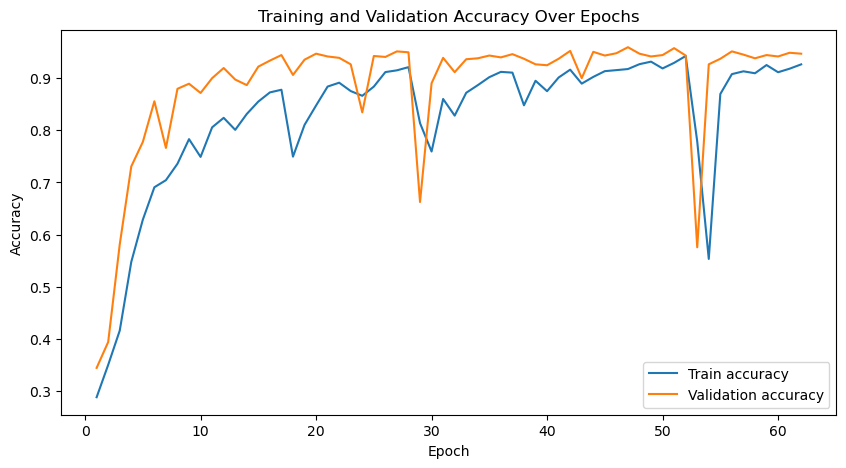

In [15]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=acc_evol, x='Epoch', y='Train accuracy', label='Train accuracy')
sns.lineplot(data=acc_evol, x='Epoch', y='Validation accuracy', label='Validation accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
y_test = to_categorical(y_test)

test_loss, test_accuracy = model_3.evaluate(X_test, y_test)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

89/89 [==============================] - 6s 73ms/step - loss: 0.2223 - accuracy: 0.9490
Test loss:  0.2222747653722763
Test accuracy:  0.9489723443984985


In [17]:
df_test = df[~df['path'].isin(df_s['path'])]
df_test["label"] = le.fit_transform(df_test["fruit"])
img_paths = df_test['path'].values
img_labels = df_test['label'].values
X = []
y = []
    
for i, path in enumerate(img_paths):
    img =  plt.imread(path)
    img = cv2.resize(img, (100,100))
    label = img_labels[i]
    X.append(img)
    y.append(label)
X = np.array(X)
y = np.array(y)
y = to_categorical(y)
fruit_names = dict(zip(le.transform(le.classes_), le.classes_))

C:\Users\ginge\AppData\Local\Temp\ipykernel_12008\2225616297.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["label"] = le.fit_transform(df_test["fruit"])


In [19]:
test_loss, test_accuracy = model_3.evaluate(X, y)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)
pred = model_3.predict(X)
pred = pred.argmax(axis=1)
df_test['predicted_label'] = pred

1764/1764 [==============================] - 150s 85ms/step - loss: 0.1962 - accuracy: 0.9531
Test loss:  0.1961568146944046
Test accuracy:  0.9531175494194031
1764/1764 [==============================] - 149s 83ms/step


C:\Users\ginge\AppData\Local\Temp\ipykernel_12008\2377784859.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_label'] = pred


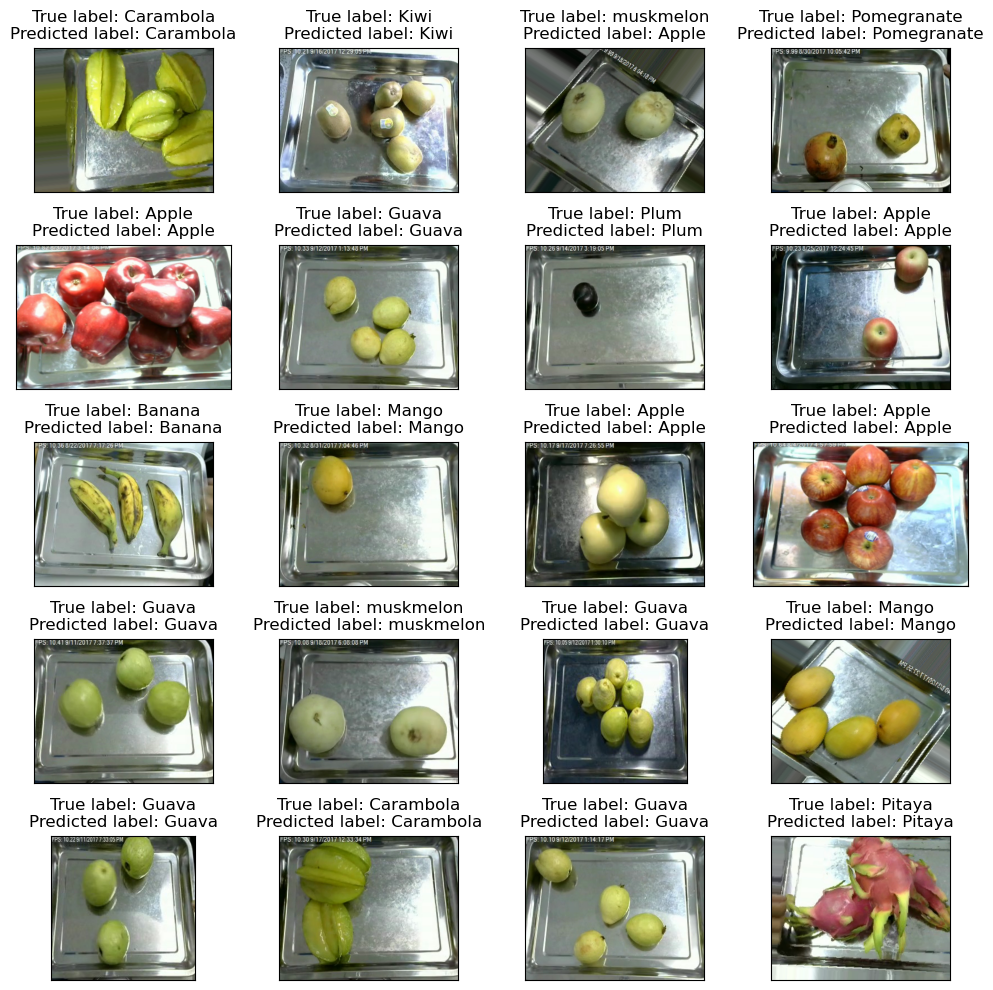

In [20]:
random = df_test.sample(20, random_state=42)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = random["path"].iloc[i]
    img = Image.open(img_path)
    ax.imshow(img)
    
    true_label_le = random['label'].iloc[i]
    predicted_label_le = random['predicted_label'].iloc[i]
    true_label = fruit_names.get(true_label_le)
    predicted_label = fruit_names.get(predicted_label_le)

    ax.set_title(f"True label: {true_label}\nPredicted label: {predicted_label}")
    
plt.tight_layout()
plt.show()

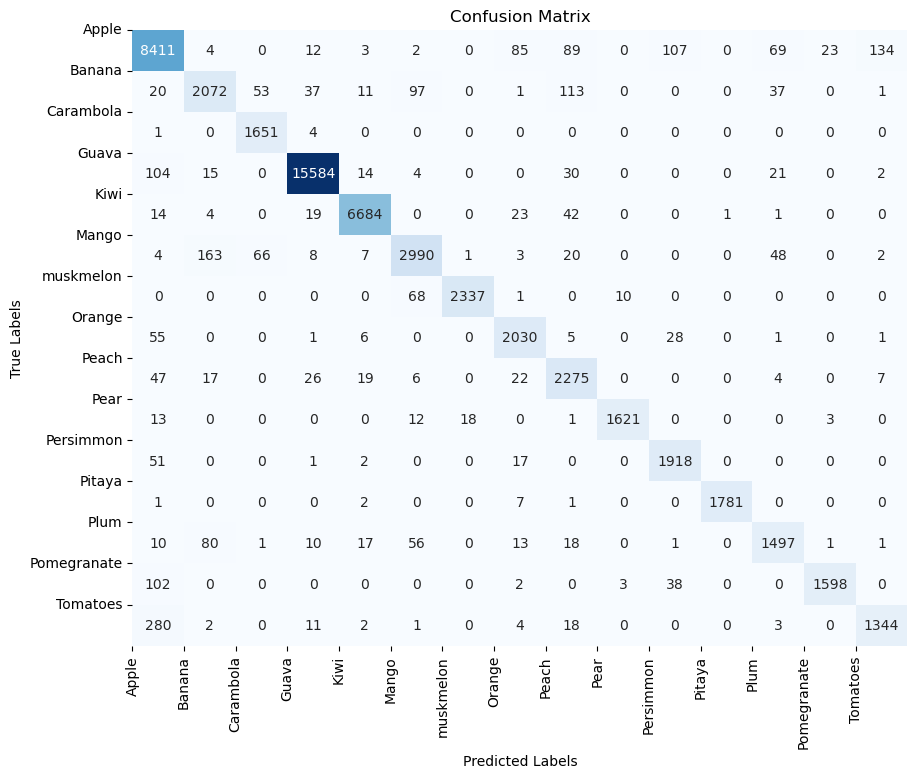

In [21]:
cm = confusion_matrix(np.array(df_test["label"]), np.array(df_test["predicted_label"]))
original_labels = df['fruit'].unique()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(fruit_names)), labels=original_labels, rotation=90)
plt.yticks(ticks=np.arange(len(fruit_names)), labels=original_labels, rotation=0)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Modelo 4

Vamos a aumentar la cantidad de datos para entrenar la red neuronal.    
Descartado (tarda muchísimo).

In [59]:
samples = round(df.shape[0]/2)
df_s = df.sample(samples, random_state=42)

le = LabelEncoder()
df_s["label"] = le.fit_transform(df_s["fruit"])

img_paths = df_s['path'].values
img_labels = df_s['label'].values
X = []
y = []
    
for i, path in enumerate(img_paths):
    img =  plt.imread(path)
    img = cv2.resize(img, (100,100))
    label = img_labels[i]
    X.append(img)
    y.append(label)
    
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = to_categorical(y_train)

In [63]:
model_4 = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(6,6), input_shape=(100,100,3), 
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(filters=128, kernel_size=(3,3),
                     activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(filters=256, kernel_size=(3,3),
                     activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(len(mapper_fruit_names), activation='softmax')
])

model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 100, 100, 32)      3488      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 50, 50, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 25, 25, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 12, 12, 128)      

In [65]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
history = model_4.fit(X_train, y_train, epochs=100, validation_split = 0.1, 
                    callbacks = early_stopping, verbose = 1)

Epoch 1/100
794/794 [==============================] - 239s 298ms/step - loss: 2.2775 - accuracy: 0.3016 - val_loss: 1.9598 - val_accuracy: 0.4047
Epoch 2/100
794/794 [==============================] - 241s 304ms/step - loss: 1.8143 - accuracy: 0.4372 - val_loss: 1.4257 - val_accuracy: 0.5170
Epoch 3/100
794/794 [==============================] - 244s 307ms/step - loss: 1.7730 - accuracy: 0.4700 - val_loss: 1.8708 - val_accuracy: 0.4968
Epoch 4/100
794/794 [==============================] - 240s 302ms/step - loss: 1.4018 - accuracy: 0.5196 - val_loss: 1.0430 - val_accuracy: 0.6038
Epoch 5/100
794/794 [==============================] - 240s 302ms/step - loss: 1.1977 - accuracy: 0.5741 - val_loss: 0.9282 - val_accuracy: 0.6701
Epoch 6/100
794/794 [==============================] - 232s 293ms/step - loss: 1.3491 - accuracy: 0.5635 - val_loss: 0.9693 - val_accuracy: 0.6432
Epoch 7/100
794/794 [==============================] - 257s 324ms/step - loss: 1.1212 - accuracy: 0.6112 - val_loss: 0

KeyboardInterrupt: 

# Modelo 5 

In [4]:
samples = round(df.shape[0]/5)

fruit_weights = 1 / df['fruit'].value_counts(normalize=True)
df_s = df.sample(samples, weights=df['fruit'].map(fruit_weights), random_state=42)
le = LabelEncoder()
df_s["label"] = le.fit_transform(df_s["fruit"])
img_paths = df_s['path'].values
img_labels = df_s['label'].values
X = []
y = []
    
for i, path in enumerate(img_paths):
    img =  plt.imread(path)
    img = cv2.resize(img, (100,100))
    label = img_labels[i]
    X.append(img)
    y.append(label)
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape
y_train = to_categorical(y_train)

In [12]:
df_s.count()

path     14110
fruit    14110
label    14110
dtype: int64

In [5]:
model_5 = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(6,6), input_shape=(100,100,3), 
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Flatten(),

    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(15, activation='softmax')
])

model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      3488      
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 50, 50, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                        

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
history = model_5.fit(X_train, y_train, epochs=100, validation_split = 0.2, 
                    callbacks = early_stopping, verbose = 1)

Epoch 1/100


283/283 [==============================] - 63s 210ms/step - loss: 2.4626 - accuracy: 0.2113 - val_loss: 3.3395 - val_accuracy: 0.0704
Epoch 2/100
283/283 [==============================] - 60s 210ms/step - loss: 1.4811 - accuracy: 0.4983 - val_loss: 4.5523 - val_accuracy: 0.0651
Epoch 3/100
283/283 [==============================] - 60s 211ms/step - loss: 1.0239 - accuracy: 0.6492 - val_loss: 4.1962 - val_accuracy: 0.0678
Epoch 4/100
283/283 [==============================] - 60s 213ms/step - loss: 0.7585 - accuracy: 0.7461 - val_loss: 4.7236 - val_accuracy: 0.1063
Epoch 5/100
283/283 [==============================] - 63s 222ms/step - loss: 0.6244 - accuracy: 0.7901 - val_loss: 3.6961 - val_accuracy: 0.1085
Epoch 6/100
283/283 [==============================] - 67s 237ms/step - loss: 0.4874 - accuracy: 0.8342 - val_loss: 4.4535 - val_accuracy: 0.0722
Epoch 7/100
283/283 [==============================] - 64s 226ms/step - loss: 0.4337 - accuracy: 0.8577 - val_loss: 3.2055

KeyboardInterrupt: 

# Model 6

In [25]:
def get_path(directory, data):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            get_path(folder_path, data)
        else:
            fruit_parts = directory.split("\\")
            fruit_name = fruit_parts[-1]
            data.append((folder_path, fruit_name))

In [26]:
directory = r".\data\archive"
data = []

get_path(directory, data)
df = pd.DataFrame(data, columns=['path', 'fruit'])

In [27]:
df = df[~df['fruit'].str.contains('total', case=False)]
df.reset_index(drop=True, inplace=True)
df['fruit'].value_counts()

fruit
Mango          4154
Banana         3027
Pear           3012
Orange         3012
Peach          2629
Pitaya         2501
Plum           2298
kiwi A         2200
Tomatoes       2171
Pomegranate    2167
Carambola      2080
muskmelon      2078
Persimmon      2072
Apple F        2030
guava B        1626
guava A        1512
Kiwi B         1067
Apple D        1033
Kiwi C         1025
Apple C        1002
Apple B         740
Apple A         692
Apple E         664
Name: count, dtype: int64

In [28]:
min_count = df['fruit'].value_counts().min()
total_samples = min_count * len(df['fruit'].unique())

df_s = pd.DataFrame()

for fruit, count in df['fruit'].value_counts().items():
    sampled_data = df[df['fruit'] == fruit].sample(min_count, random_state=42)
    df_s = pd.concat([df_s, sampled_data])

df_s.reset_index(inplace=True)

In [29]:
print(df_s.shape[0])
df_s['fruit'].value_counts()

15272


fruit
Mango          664
Persimmon      664
Apple A        664
Apple B        664
Apple C        664
Kiwi C         664
Apple D        664
Kiwi B         664
guava A        664
guava B        664
Apple F        664
muskmelon      664
Banana         664
Carambola      664
Pomegranate    664
Tomatoes       664
kiwi A         664
Plum           664
Pitaya         664
Peach          664
Orange         664
Pear           664
Apple E        664
Name: count, dtype: int64

In [30]:
add_samples = df[~df['path'].isin(df_s.index)]
add_samples = add_samples.sample(10000)

df_s = pd.concat([df_s, add_samples])
df_s.reset_index(drop=True, inplace=True)

print(df_s.shape[0])
df_s['fruit'].value_counts()

25272


fruit
Mango          1567
Banana         1350
Orange         1310
Pear           1306
Peach          1261
Pitaya         1217
Plum           1185
Persimmon      1163
Pomegranate    1152
Tomatoes       1150
kiwi A         1145
Carambola      1138
muskmelon      1120
Apple F        1090
guava B        1046
guava A        1012
Kiwi B          924
Apple D         906
Apple C         885
Kiwi C          884
Apple B         841
Apple A         814
Apple E         806
Name: count, dtype: int64

In [31]:
le = LabelEncoder()
df_s["label"] = le.fit_transform(df_s["fruit"])

img_paths = df_s['path'].values
img_labels = df_s['label'].values
X = []
y = []
    
for i, path in enumerate(img_paths):
    img =  plt.imread(path)
    img = cv2.resize(img, (100,100))
    label = img_labels[i]
    X.append(img)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [33]:
model_6 = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(100,100,3), 
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=128, kernel_size=(3,3),
                     activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=256, kernel_size=(3,3),
                     activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(23, activation='softmax')
])

model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
model_6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 12, 12, 128)      

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
history = model_6.fit(X_train, y_train, epochs=100, validation_split = 0.2, 
                    callbacks = early_stopping, verbose = 1)

Epoch 1/100
506/506 [==============================] - 154s 300ms/step - loss: 2.7980 - accuracy: 0.1068 - val_loss: 2.3512 - val_accuracy: 0.2253
Epoch 2/100
506/506 [==============================] - 150s 296ms/step - loss: 1.8983 - accuracy: 0.3428 - val_loss: 1.0599 - val_accuracy: 0.6224
Epoch 3/100
506/506 [==============================] - 171s 338ms/step - loss: 1.0894 - accuracy: 0.6048 - val_loss: 0.5697 - val_accuracy: 0.8316
Epoch 4/100
506/506 [==============================] - 170s 336ms/step - loss: 0.7136 - accuracy: 0.7464 - val_loss: 0.3001 - val_accuracy: 0.9147
Epoch 5/100
506/506 [==============================] - 169s 333ms/step - loss: 0.5299 - accuracy: 0.8130 - val_loss: 0.2074 - val_accuracy: 0.9369
Epoch 6/100
506/506 [==============================] - 170s 336ms/step - loss: 0.4411 - accuracy: 0.8476 - val_loss: 0.1639 - val_accuracy: 0.9525
Epoch 7/100
506/506 [==============================] - 159s 315ms/step - loss: 0.3641 - accuracy: 0.8780 - val_loss: 0

In [36]:
test_loss, test_accuracy = model_6.evaluate(X_test, y_test)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

158/158 [==============================] - 12s 75ms/step - loss: 0.0520 - accuracy: 0.9854
Test loss:  0.051982246339321136
Test accuracy:  0.9853610396385193


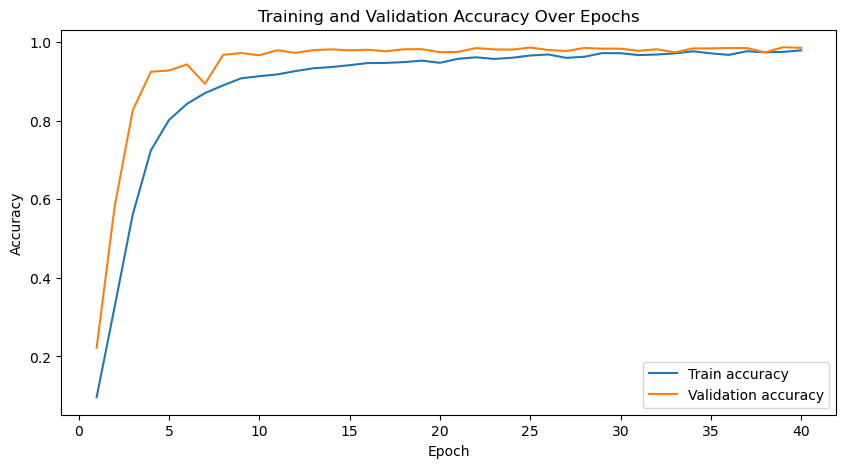

In [51]:
acc_evol = {'Train accuracy': history.history['accuracy'], 
            'Validation accuracy': history.history['val_accuracy'], 
            'Epoch': range(1, 41)}

acc_evol = pd.DataFrame(acc_evol)
plt.figure(figsize=(10, 5))
sns.lineplot(data=acc_evol, x='Epoch', y='Train accuracy', label='Train accuracy')
sns.lineplot(data=acc_evol, x='Epoch', y='Validation accuracy', label='Validation accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
pred = model_6.predict(X)
pred = pred.argmax(axis=1)
df_s['predicted_label'] = pred

790/790 [==============================] - 64s 79ms/step


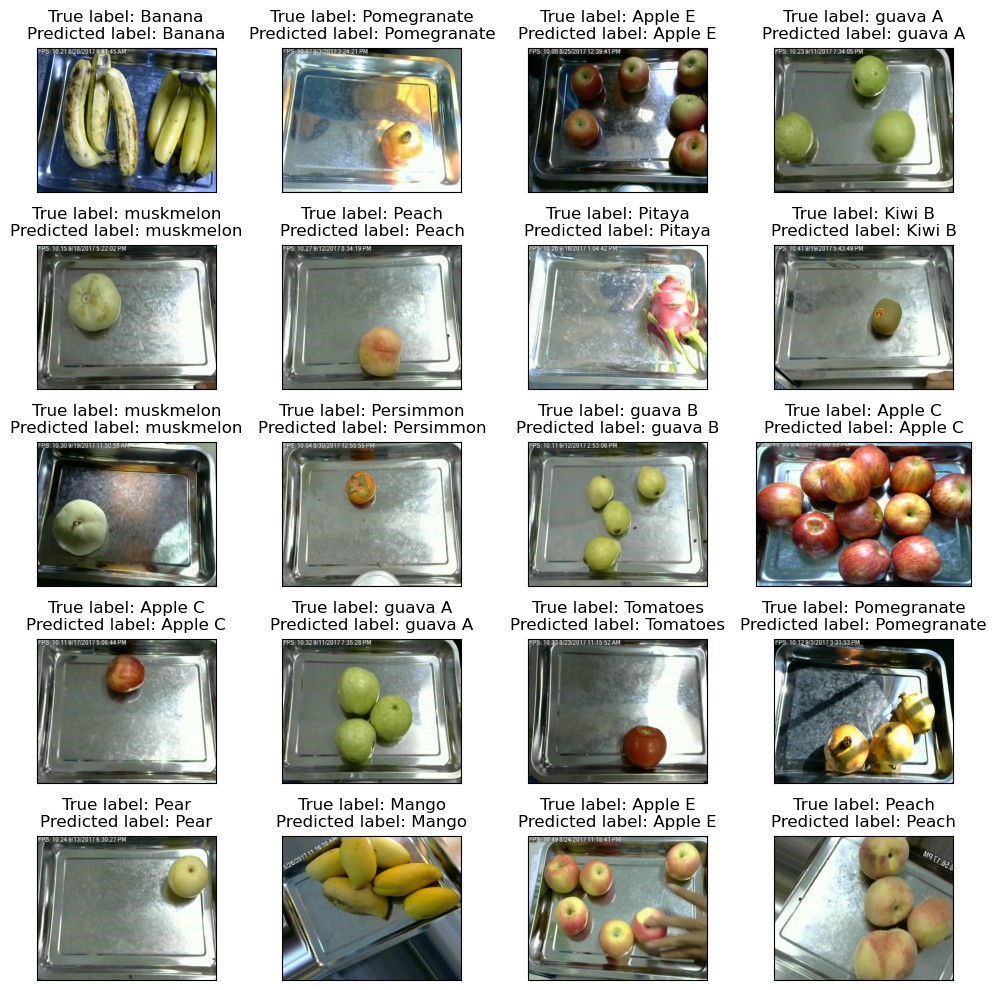

In [38]:
fruit_names = dict(zip(le.transform(le.classes_), le.classes_))

random = df_s.sample(20, random_state=42)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = random["path"].iloc[i]
    img = Image.open(img_path)
    ax.imshow(img)
    
    true_label_le = random['label'].iloc[i]
    predicted_label_le = random['predicted_label'].iloc[i]
    true_label = fruit_names.get(true_label_le)
    predicted_label = fruit_names.get(predicted_label_le)

    ax.set_title(f"True label: {true_label}\nPredicted label: {predicted_label}")
    
plt.tight_layout()
plt.show()

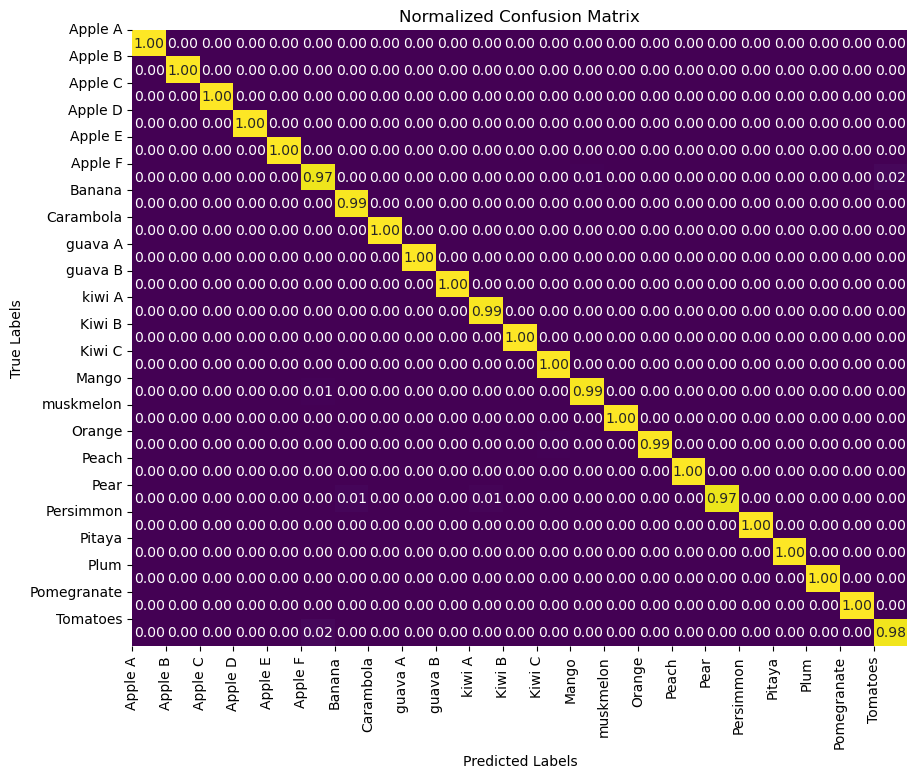

In [46]:
cm = confusion_matrix(np.array(df_s["label"]), np.array(df_s["predicted_label"]))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
original_labels = df['fruit'].unique()

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='viridis', cbar=False)
plt.xticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=90)
plt.yticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=0)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


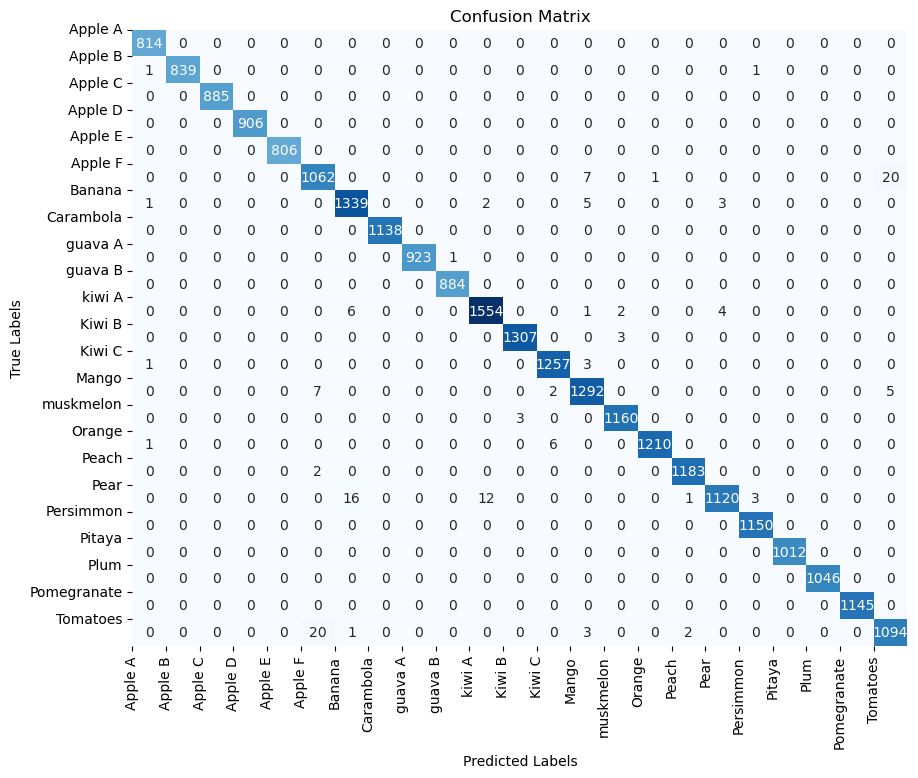

In [39]:
cm = confusion_matrix(np.array(df_s["label"]), np.array(df_s["predicted_label"]))
original_labels = df['fruit'].unique()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(fruit_names)), labels=original_labels, rotation=90)
plt.yticks(ticks=np.arange(len(fruit_names)), labels=original_labels, rotation=0)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [40]:
df_error = df_s[df_s['label'] != df_s['predicted_label']]
df_error.shape

(146, 5)

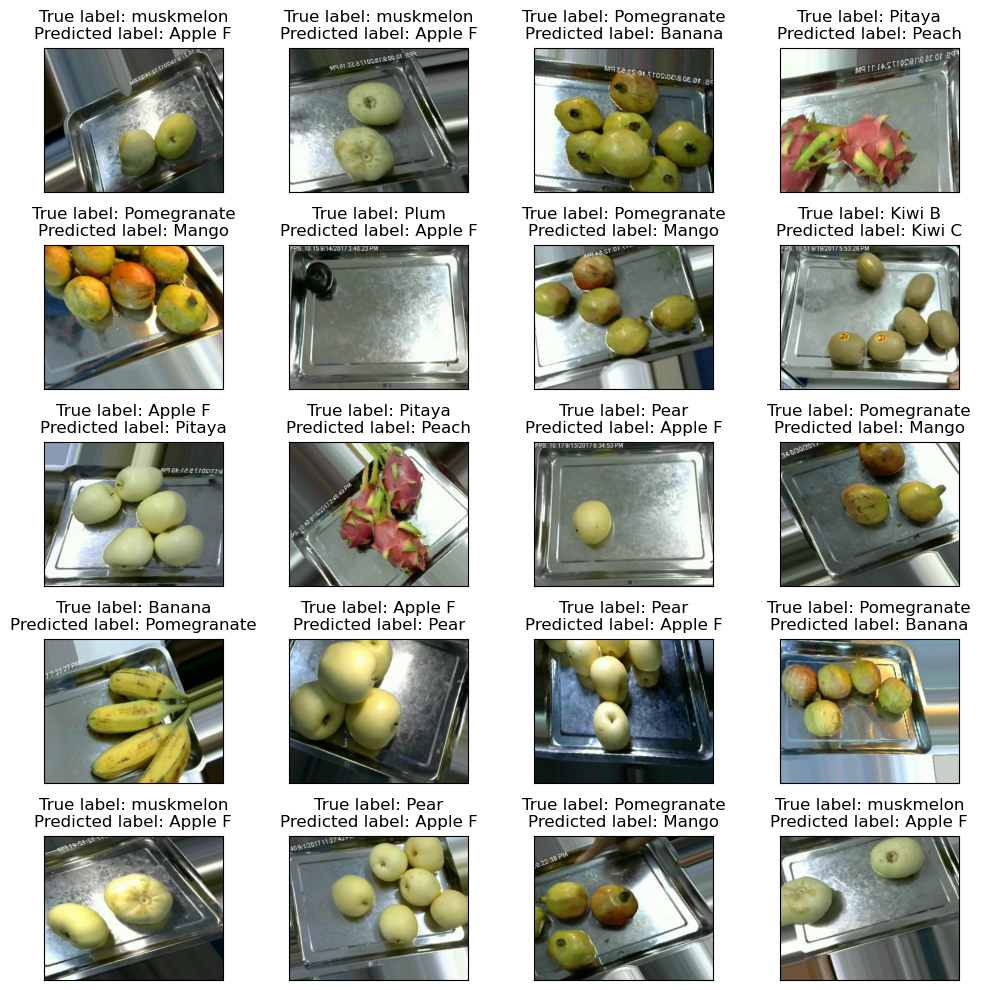

In [41]:
random = df_error.sample(20, random_state=42)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = random["path"].iloc[i]
    img = Image.open(img_path)
    ax.imshow(img)
    
    true_label_le = random['label'].iloc[i]
    predicted_label_le = random['predicted_label'].iloc[i]
    true_label = fruit_names.get(true_label_le)
    predicted_label = fruit_names.get(predicted_label_le)

    ax.set_title(f"True label: {true_label}\nPredicted label: {predicted_label}")
    
plt.tight_layout()
plt.show()

In [42]:
df_test = df[~df['path'].isin(df_s['path'])]
df_test["label"] = le.fit_transform(df_test["fruit"])
img_paths = df_test['path'].values
img_labels = df_test['label'].values
X = []
y = []
    
for i, path in enumerate(img_paths):
    img =  plt.imread(path)
    img = cv2.resize(img, (100,100))
    label = img_labels[i]
    X.append(img)
    y.append(label)
X = np.array(X)
y = np.array(y)
y = to_categorical(y)
fruit_names = dict(zip(le.transform(le.classes_), le.classes_))
test_loss, test_accuracy = model_1.evaluate(X, y)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

C:\Users\ginge\AppData\Local\Temp\ipykernel_4456\2091260104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["label"] = le.fit_transform(df_test["fruit"])


InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\ginge\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\ginge\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\ginge\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\ginge\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\ginge\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\ginge\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\ginge\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\ginge\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\ginge\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\ginge\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\ginge\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\ginge\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\ginge\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\ginge\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\ginge\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\ginge\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\ginge\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\ginge\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\ginge\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\ginge\AppData\Local\Temp\ipykernel_4456\2091260104.py", line 18, in <module>

  File "C:\Users\ginge\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\ginge\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2296, in evaluate

  File "C:\Users\ginge\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 4108, in run_step

  File "C:\Users\ginge\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2066, in test_function

  File "C:\Users\ginge\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2049, in step_function

  File "C:\Users\ginge\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2037, in run_step

  File "C:\Users\ginge\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1919, in test_step

  File "C:\Users\ginge\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss

  File "C:\Users\ginge\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "C:\Users\ginge\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "C:\Users\ginge\anaconda3\Lib\site-packages\keras\src\losses.py", line 270, in call

  File "C:\Users\ginge\anaconda3\Lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy

  File "C:\Users\ginge\anaconda3\Lib\site-packages\keras\src\backend.py", line 5579, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,15] labels_size=[32,22]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_test_function_179432]

# Model 6_1

In [61]:
model_6_1 = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(100,100,3), 
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                        activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=128, kernel_size=(3,3),
                     activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(3,3),
                     activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(23, activation='softmax')
])

model_6_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
model_6_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 50, 50, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_16 (Ba  (None, 50, 50, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_32 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 25, 25, 64)        0         
 ng2D)                                                           
                                                      

In [63]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
history = model_6_1.fit(X_train, y_train, epochs=100, validation_split = 0.2, 
                    callbacks = early_stopping, verbose = 1)

Epoch 1/100
506/506 [==============================] - 192s 374ms/step - loss: 3.0192 - accuracy: 0.1098 - val_loss: 3.1708 - val_accuracy: 0.1627
Epoch 2/100
506/506 [==============================] - 190s 375ms/step - loss: 2.7348 - accuracy: 0.1781 - val_loss: 2.3734 - val_accuracy: 0.2918
Epoch 3/100
506/506 [==============================] - 193s 382ms/step - loss: 2.4172 - accuracy: 0.2436 - val_loss: 2.2530 - val_accuracy: 0.3455
Epoch 4/100
506/506 [==============================] - 188s 372ms/step - loss: 2.0990 - accuracy: 0.3201 - val_loss: 1.7348 - val_accuracy: 0.4162
Epoch 5/100
506/506 [==============================] - 187s 369ms/step - loss: 1.8087 - accuracy: 0.3933 - val_loss: 1.7728 - val_accuracy: 0.4273
Epoch 6/100
506/506 [==============================] - 186s 367ms/step - loss: 1.6142 - accuracy: 0.4535 - val_loss: 1.2194 - val_accuracy: 0.6140
Epoch 7/100
506/506 [==============================] - 191s 378ms/step - loss: 1.3801 - accuracy: 0.5196 - val_loss: 0

KeyboardInterrupt: 